# Correlation: Relationships between columns

**TurboPanda** still has more to offer to allow seemless flowing of `pandas`-like operations, and indeed into `scikit-learn`.

In [8]:
import sys
import numpy as np
import pandas as pd
sys.path.insert(0,"../")
# our main import
import turbopanda as turb

import matplotlib.pyplot as plt
%matplotlib inline

print(turb.__version__)

0.2.8


In [9]:
g = turb.read("../data/rna.csv", name="rna")
g

MetaPanda(rna(n=100, p=117, mem=0.187MB, options=[]))

In [10]:
g.columns

Index(['counter', 'refseq_id', 'G_mrna', 'A_mrna', 'C_mrna', 'T_mrna',
       'length_mrna', 'GC_content_mrna', 'length_cds', 'length_prop_cds',
       ...
       'ncRNA_fc', 'precursor_RNA_bs', 'misc_feature_fc', 'sig_peptide_fc',
       'STS_fc', 'regulatory_fc', 'mat_peptide_fc', 'exon_fc', 'proprotein_bs',
       'transit_peptide_fc'],
      dtype='object', name='colnames', length=117)

## Determining the relationship between columns in a DataFrame

In `pandas`, there exists a basic correlation function `corr()` which takes
 a method type among other things and returns a correlation matrix. I 
 found this to be clunky and unreliable. Not only this, but it lacks options in terms of
 different types of correlation methods and different formats, for instance 
 in the following cases:

1. *Case one*: when two features are **not both** continuous.
2. *Case two*: when features are not type-casted properly due to `pandas` poor 
handling of missing data.
3. *Case three*: when desiring to compare *between* two datasets (say Matrix and Vector).
 `pandas` only provides intra-correlations between features in a *single dataframe*.

***

Note that matrices must be completely overlapping in order to correlate variables together. It doesn't
make sense otherwise.

| Use case | `pandas` response | `turbopanda` response |
| --------------------- | ----------------- | --------------- |
| One matrix $X$ | Correlates all using `method`<br>parameter (spearman, pearson)<br>returning Matrix | Correlates all using most<br>appropriate method (spearman,<br>pearson for continuous, biserial for boolean/cont)<br>returning list of interactions |
| Two vectors $x$,$y$ of same shape | Does not handle | Correlates using appropriate method<br>returning single value |
| One matrix $X$, one Vector $y$ | Does not handle | Correlates every column $X_i$ to vector $y$<br>using appropriate method returning<br>Vector $z$ |
| Two matrices $X$,$Y$ of same shape | Does not handle | Correlates column $X_i$ with $Y_i$ using <br>most appropriate method returning<br>Vector $z$ |
| Two matrices $X$,$Y$ of different shapes | Does not handle | Correlates every column $X_i$ with $Y_j$ using <br>most appropriate method returning<br>returning list of interactions |
 
***

In `turbopanda`, we have a dedicated `correlate()` function which handles missing,
 heterogenous datasets.
 
Note that there must be NO columns of object type or any other non-numeric data type
before calling:


In [11]:
corr = turb.correlate(g[float])
corr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136 entries, 0 to 135
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   x           136 non-null    object 
 1   y           136 non-null    object 
 2   n           136 non-null    int64  
 3   method      136 non-null    object 
 4   r           136 non-null    float64
 5   r2          136 non-null    float64
 6   adj_r2      136 non-null    float64
 7   CI95_lower  136 non-null    float64
 8   CI95_upper  136 non-null    float64
 9   p_val       136 non-null    float64
 10  power       136 non-null    float64
 11  outliers    0 non-null      float64
dtypes: float64(8), int64(1), object(3)
memory usage: 12.9+ KB


In [12]:
corr.head()

,x,y,n,method,r,r2,adj_r2,CI95_lower,CI95_upper,p_val,power,outliers
0,GC_content_mrna,GC_content_mrna,100,spearman,1.000,1.000,1.000,1.00,1.00,0.000000,1.000,NaN
1,GC_content_mrna,length_prop_cds,100,spearman,0.271,0.073,0.054,0.08,0.44,0.006481,0.784,NaN
2,GC_content_mrna,length_prop_utr5,100,spearman,0.093,0.009,-0.012,-0.11,0.28,0.357553,0.152,NaN
3,GC_content_mrna,MFE,100,spearman,0.085,0.007,-0.013,-0.11,0.28,0.402649,0.134,NaN
4,GC_content_mrna,MFE_win10,100,spearman,-0.224,0.050,0.031,-0.40,-0.03,0.025008,0.616,NaN


What we see is a list of correlation experiments, given column $x$ and $y$, we get the method used,
confidence intervals, $r$ and $r^2$, $n$, p-values and estimated power.

## Obtaining a correlation matrix

From these sets of rows, it is common to want to convert this into matrix-form using either $r$, $r^2$, or some other parameter.

In [13]:
M = turb.corr.row_to_matrix(corr)

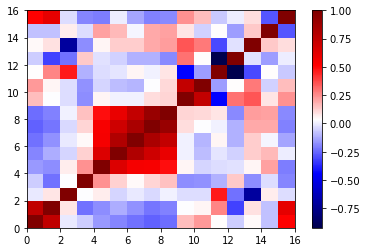

In [14]:
plt.pcolormesh(M, cmap="seismic")
plt.colorbar()
plt.show()

## Calculating a simple bi-correlation

We also can handle simple use cases of bi-correlation between two vectors, which
determines automatically which correlation method is the most appropriate to use, if requested.

To achieve this, we implement the `bicorr` method, where in this case as both columns are integers,
we use Spearman-rank correlation:

In [17]:
turb.corr.bicorr(g['length_mrna'], g['length_cds'])

0.501

We can also return a fuller output if we so choose:

In [23]:
turb.corr.bicorr(g['length_mrna'], g['length_cds'], output='full')

{'x': 'length_mrna',
 'y': 'length_cds',
 'n': 100,
 'method': 'spearman',
 'r': 0.501,
 'r2': 0.251,
 'adj_r2': 0.235,
 'CI95_lower': 0.34,
 'CI95_upper': 0.63,
 'p_val': 1.1150527602741492e-07,
 'power': 1.0,
 'outliers': nan}

### Controlling for other factors: Partial correlation

We can control for a vector or matrix of confounding factors using `partial_bicorr`
which we pass the full matrix, with string names of `x`, `y` and `covar` which represents
a string or list of str names as confounding factors. Note that in this example all variables must be
continuous as under-the-hood a linear model is developed for both x and y, and key assumptions
are broken regarding the residuals if this is not the case.

In [22]:
print("Normal corr: %.3f, Partial corr: %.3f" % (
    turb.corr.bicorr(g['RCBS'], g['CAI']),
    turb.corr.partial_bicorr(g.df_, "RCBS", "CAI", "length_prop_cds")
))
# here we see controlling for proportion length, 5% of the correlation is removed.

Normal corr: 0.164, Partial corr: 0.115


## Plotting the correlation matrix using Hinton

As of version 0.2.8, the `hinton` method within plotting receives a Pandas DataFrame
which is a symmetric correlation matrix, along with other parameters, and plots
a more sophisticated hinton-esque heatmap. This is nice as it emphasises important correlations
by square size as well as colour.

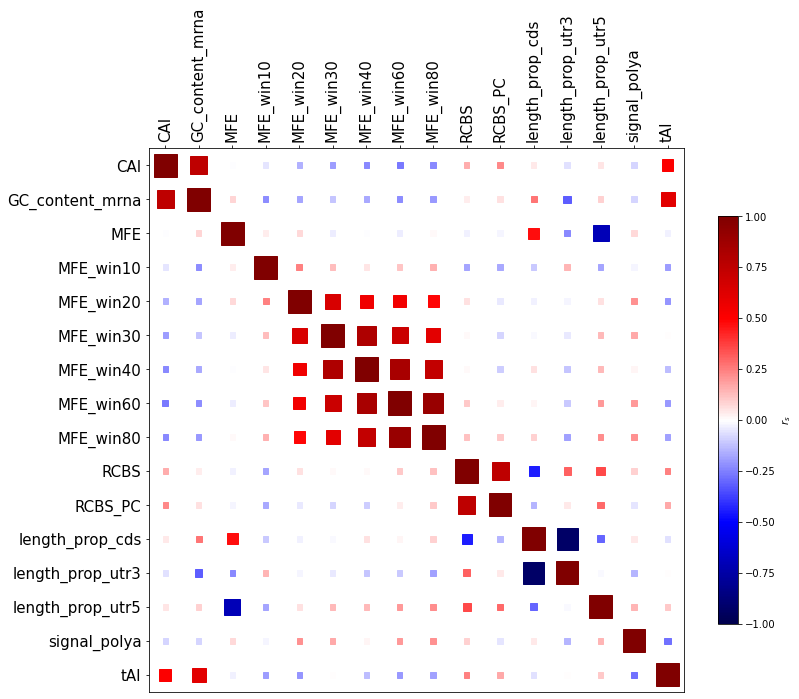

In [16]:
ax = turb.plot.hinton(M, pad=0.02)
ax.tick_params(labelsize=15)